## Style Transfer Using GAN (CycleGAN)

### Variables, Hyperparamaters and libraries import

In [147]:
# from google.colab import drive
# drive.mount('/content/drive')

# PLATFORM = 'collab'
PLATFORM = 'kaggle'
# PLATFORM = ''

In [148]:
# %pip install -r requirements.txt
# %pip install git+https://github.com/tensorflow/docs

In [149]:
import os 
import time
import glob
import pickle
import imageio

import numpy as np
import pandas as pd
import tensorflow as tf
from numpy import asarray
from skimage.io import imread 

import matplotlib.pyplot as plt
from skimage.transform import resize
import tensorflow_docs.vis.embed as embed
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import img_to_array, load_img, array_to_img

In [150]:
if PLATFORM == 'collab':
    SOURCE_FOLDER = '/content/drive/MyDrive/Colab Notebooks/projects/Style-Transfer-using-GAN/Source/'
    T1_FOLDER = SOURCE_FOLDER + 'Tr1/TrainT1/'
    T2_FOLDER = SOURCE_FOLDER + 'Tr2/TrainT2/'
    OUTPUT_FOLDER = './Output/'
elif PLATFORM == 'kaggle':
    SOURCE_FOLDER = '/kaggle/input/cyclegan-dataset/'
    T1_FOLDER = SOURCE_FOLDER + 'Tr1/TrainT1/'
    T2_FOLDER = SOURCE_FOLDER + 'Tr2/TrainT2/'
    OUTPUT_FOLDER = './Output/'
else:
    SOURCE_FOLDER = './Source/'
    T1_FOLDER = SOURCE_FOLDER + 'Tr1/TrainT1/'
    T2_FOLDER = SOURCE_FOLDER + 'Tr2/TrainT2/'
    OUTPUT_FOLDER = './Output/'

# TIMESTAMP = str(time.strftime('%Y%m%d%H%M%S'))  
TIMESTAMP = '20250509110606'
restore_checkpoint = False
TEMP_FOLDER = OUTPUT_FOLDER + TIMESTAMP + '/'

if os.path.exists(OUTPUT_FOLDER):
    if os.path.exists(TEMP_FOLDER) != True:
        os.mkdir(TEMP_FOLDER)
else:
    os.mkdir(OUTPUT_FOLDER)
    os.mkdir(TEMP_FOLDER)

EPOCHS = 30
BATCH_SIZE = 1 
IMG_WIDTH = 256
IMG_HEIGHT = 256
BUFFER_SIZE = 1000

### Data Initialization

(43, 256, 256, 1)
(46, 256, 256, 1)


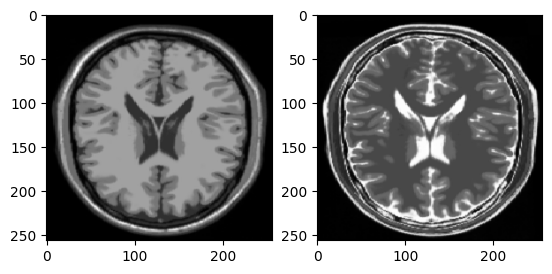

In [151]:
# load and resize images
def load_images(path, size=(IMG_HEIGHT, IMG_WIDTH)):
    images = glob.glob(path+'*.png')
    data_list = list()

    for filename in images:
        pixels = load_img(filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store the data
        data_list.append(pixels)
    return asarray(data_list)

t1_images = load_images(T1_FOLDER)
t2_images = load_images(T2_FOLDER)

tr1_data = tf.image.rgb_to_grayscale(t1_images)
tr2_data = tf.image.rgb_to_grayscale(t2_images)

print(tr1_data.shape)
print(tr2_data.shape)

tr1_dt= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr1_data))
tr2_dt= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr2_data))

fig, axs = plt.subplots(1,2)
axs[0].imshow(tr1_data[0], cmap='gray')
axs[1].imshow(tr2_data[0], cmap='gray')
plt.show();

### Image Preprocessing

In [152]:
# t1_images = np.zeros((t1_df.shape[0], IMG_HEIGHT, IMG_WIDTH))
# t2_images = np.zeros((t2_df.shape[0], IMG_HEIGHT, IMG_WIDTH))

# for idx, img in enumerate(t1_df['img_pxl']):
#     t1_images[idx, :, :] = resize(img, (IMG_HEIGHT, IMG_WIDTH))

# for idx, img in enumerate(t2_df['img_pxl']):
#     t2_images[idx, :, :] = resize(img, (IMG_HEIGHT, IMG_WIDTH))

# t1_images.shape    
# t2_images.shape

# t1_images = (t1_images/127.5)-1.0
# t2_images = (t2_images/127.5)-1.0

# t1_images = t1_images.reshape(t1_images.shape[0], IMG_HEIGHT, IMG_WIDTH, 1).astype('float32')
# t2_images = t2_images.reshape(t2_images.shape[0], IMG_HEIGHT, IMG_WIDTH, 1).astype('float32')

# t1_img_data = tf.data.Dataset.from_tensor_slices(t1_images).shuffle(t1_images.shape[0], seed=42).batch(BATCH_SIZE)
# t2_img_data = tf.data.Dataset.from_tensor_slices(t2_images).shuffle(t2_images.shape[0], seed=42).batch(BATCH_SIZE)

#### Image Normalization, Shuffling and Batch Processing

In [153]:
def normalize(image):
    image =  tf.cast(image, tf.float32)
    image= (image / 127.5) - 1
    return image

def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

AUTOTUNE = tf.data.experimental.AUTOTUNE
# tr1 = tr1_dt.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# tr2 = tr2_dt.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

tr1 = tr1_dt.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tr2 = tr2_dt.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

sample_t1_data = next(iter(tr1))
sample_t2_data = next(iter(tr2))

#### Augmentation Tryouts

In [154]:
# #Simulates thermal/electronic noise in scanners
# def add_gaussian_noise(image, mean=0.0, stddev=15.0):
#     noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
#     noisy_image = tf.clip_by_value(image + noise, 0.0, 255.0)
#     return noisy_image

# # Mimics scanner calibration issues
# def intensity_shift(image, shift_range=30):
#     shift = tf.random.uniform([], -shift_range, shift_range, dtype=tf.float32)
#     shifted_image = image + shift
#     return tf.clip_by_value(shifted_image, 0.0, 255.0)


# #Simulates non-uniform magnetic field causing smooth illumination bias
# def intensity_gradient(image):
#     height, width, _ = image.shape
#     gradient = tf.linspace(0.8, 1.2, width)
#     gradient = tf.reshape(gradient, (1, width, 1))
#     biased_image = image * gradient
#     return tf.clip_by_value(biased_image, 0.0, 255.0)

# #MRI scans from different scanners may have varying contrast levels
# def random_contrast(image, lower=0.7, upper=1.3):
#     # Contrast variation in the range [0, 255]
#     contrast_factor = tf.random.uniform([], lower, upper)
#     contrast_image = image * contrast_factor
#     return tf.clip_by_value(contrast_image, 0.0, 255.0)

In [155]:
# # Visualize all
# fig, axs = plt.subplots(2, 5, figsize=(20, 5))

# axs[0][0].imshow(tr1_data[0], cmap="gray")  # Original
# axs[0][0].set_title('Original T1')
# axs[0][1].imshow(add_gaussian_noise(tr1_data[0]), cmap="gray")
# axs[0][1].set_title('Gaussian Noise')
# axs[0][2].imshow(intensity_gradient(tr1_data[0]), cmap="gray")
# axs[0][2].set_title('Biased Magnetic Field')
# axs[0][3].imshow(random_contrast(tr1_data[0]), cmap="gray")
# axs[0][3].set_title('Randomized Contrast')
# axs[0][4].imshow(intensity_shift(tr1_data[0]), cmap="gray")
# axs[0][4].set_title('Intensity Shift')
# axs[1][0].imshow(tr2_data[0], cmap="gray")  # Original
# axs[1][0].set_title('Original T2')
# axs[1][1].imshow(add_gaussian_noise(tr2_data[0]), cmap="gray")
# axs[1][1].set_title('Gaussian Noise')
# axs[1][2].imshow(intensity_gradient(tr2_data[0]), cmap="gray")
# axs[1][2].set_title('Biased Magnetic Field')
# axs[1][3].imshow(random_contrast(tr2_data[0]), cmap="gray")
# axs[1][3].set_title('Randomized Contrast')
# axs[1][4].imshow(intensity_shift(tr2_data[0]), cmap="gray")
# axs[1][4].set_title('Intensity Shift')

# for ax in axs:
#     for a in ax:
#         a.axis('off')

# plt.show();

In [156]:
# seed = (1, 2)
# fig, axs = plt.subplots(1,4)

# axs[0].imshow(array_to_img(t1_images[0]), cmap='gray')
# axs[1].imshow(tf.image.adjust_brightness(array_to_img(t1_images[0]), delta=0.5))
# axs[2].imshow(tf.image.stateless_random_brightness(array_to_img(t1_images[0]),0.2,seed = (1, 2)), cmap='gray')
# axs[3].imshow(array_to_img(t2_images[0]), cmap='gray')
# plt.show();

### Loss Functions & Optimizer 

In [157]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Model Building

#### Instance Normalization

In [158]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__() # calling parent's init
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### Downsampling and Upsampling

In [159]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
        
    # Add Leaky Relu Activation 
    # result.add(tf.keras.layers.LeakyReLU())
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    # Add Normalization Layer
    result.add(InstanceNormalization())
    
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

#### Generator

In [160]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
    
    down_stack = [
        downsample(64, 4, True),
        downsample(128, 4, True),
        downsample(256, 4, True),
        downsample(512, 4),
        
        # downsample(512, 4),
        # downsample(512, 4),
        # downsample(512, 4),
        # downsample(512, 4)
        
        # downsample(64, 4, False), # (bs, 16, 16, 64)
        # downsample(128, 4), # (bs, 8, 8, 128)
        # downsample(128, 4), # (bs, 4, 4, 128)
        # downsample(128, 4), # (bs, 2, 2, 128)
        # downsample(128, 4) # (bs, 1, 1, 128)
    ]
    up_stack = [
        upsample(512, 4, True),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4)
        
        # upsample(512, 4, True),
        # upsample(512, 4, True),
        # upsample(512, 4),

        # upsample(128, 4, True), # (bs, 2, 2, 256)
        # upsample(128, 4, True), # (bs, 4, 4, 256)
        # upsample(128, 4), # (bs, 8, 8, 256)
        # upsample(64, 4) # (bs, 16, 16, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') # (bs, 32, 32, 1)
    concat = tf.keras.layers.Concatenate()
    
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1])
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [161]:
generator_g = unet_generator()
generator_f = unet_generator()

generator_g.summary()

Model: "functional_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_146           │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_159            │ (None, 128, 128, 64)   │          1,152 │ input_layer_146[0][0]  │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_160            │ (None, 64, 64, 128)    │        131,328 │ sequential_159[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_161            │ (None, 32, 32, 256)    │        524,800 │ sequential_160[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_162            │ (None, 16, 16, 512)    │      2,098,176 │ sequential_161[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_163            │ (None, 32, 32, 512)    │      4,195,328 │ sequential_162[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_14            │ (None, 128, 128, 192)  │              0 │ sequential_163[0][0],  │
│ (Concatenate)             │                        │                │ sequential_161[0][0],  │
│                           │                        │                │ sequential_164[0][0],  │
│                           │                        │                │ sequential_160[0][0],  │
│                           │                        │                │ sequential_165[0][0],  │
│                           │                        │                │ sequential_159[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_164            │ (None, 64, 64, 256)    │      3,146,240 │ concatenate_14[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_165            │ (None, 128, 128, 128)  │        786,688 │ concatenate_14[1][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_84       │ (None, 256, 256, 1)    │          3,073 │ concatenate_14[2][0]   │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,886,785 (41.53 MB)

 Trainable params: 10,886,785 (41.53 MB)

 Non-trainable params: 0 (0.00 B)

#### Discriminator

In [162]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used 
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (32, 32, 1)
    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='input_image')
    x = inp
    
    # add downsampling step here
    down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64)
    down2 = downsample(128, 4)(down1) # (bs, 8, 8, 128)
    down3 = downsample(256, 4)(down2)
    
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 10, 10, 128)
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) 
    # conv = tf.keras.layers.Conv2D(256, 4, strides=1, kernel_initializer=initializer,
    #                               use_bias=False)(zero_pad1) # (bs, 7, 7, 256)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 256)
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [163]:
discriminator_x = discriminator()
discriminator_y = discriminator()

discriminator_x.summary()

Model: "functional_171"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_175 (Sequential)          │ (None, 128, 128, 64)        │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_176 (Sequential)          │ (None, 64, 64, 128)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_177 (Sequential)          │ (None, 32, 32, 256)         │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_20 (ZeroPadding2D)    │ (None, 34, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_124 (Conv2D)                  │ (None, 31, 31, 512)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ instance_normalization_166           │ (None, 31, 31, 512)         │           1,024 │
│ (InstanceNormalization)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_113 (LeakyReLU)          │ (None, 31, 31, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_21 (ZeroPadding2D)    │ (None, 33, 33, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_125 (Conv2D)                  │ (None, 30, 30, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,763,521 (10.54 MB)

 Trainable params: 2,763,521 (10.54 MB)

 Non-trainable params: 0 (0.00 B)

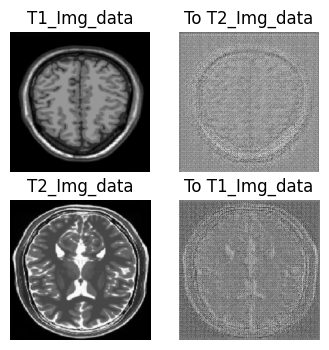

In [164]:
to_t2_img_data = generator_g(sample_t1_data)
to_t1_img_data = generator_f(sample_t2_data)
plt.figure(figsize=(4, 4))

imgs = [sample_t1_data, to_t2_img_data, sample_t2_data, to_t1_img_data]
title = ['T1_Img_data', 'To T2_Img_data', 'T2_Img_data', 'To T1_Img_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0], cmap='gray')
    plt.axis('off')
plt.show();

### Model Training

#### Checkpoint Initialization

In [165]:
checkpoint_path = TEMP_FOLDER +"Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint and restore_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [166]:
def generate_images(model1, test_input1, model2, test_input2, epoch):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig(TEMP_FOLDER +'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show();

In [167]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        total_id_loss = identity_loss(real_y, same_y) + identity_loss(real_x, same_x)
        
        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))
    
    return {
        'gen_g_loss': gen_g_loss, 'gen_f_loss': gen_f_loss,
        'cycle_loss': total_cycle_loss, 'identity_loss': total_id_loss,
        'disc_x_loss': disc_x_loss, 'disc_y_loss': disc_y_loss
    }

In [168]:
# for epoch in range(1, EPOCHS+1):
#     for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
#         train_step(image_x, image_y)
#     generate_images(generator_g, sample_t1_data, generator_f, sample_t2_data, epoch)
#     ckpt_save_path = ckpt_manager.save()
#     print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)


Epoch 1/30


E0000 00:00:1746790551.416477      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_159_1/sequential_163_1/dropout_20_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Avg Losses -> GenG: 0.9896, GenF: 0.9843, Cycle: 3.9040, Identity: 0.2080, DiscX: 0.6695, DiscY: 0.6975


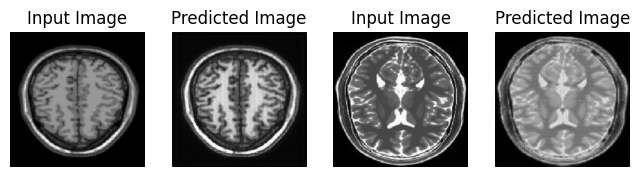

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-1

Epoch 2/30
Avg Losses -> GenG: 1.0604, GenF: 1.1362, Cycle: 1.7362, Identity: 0.1056, DiscX: 0.5263, DiscY: 0.5593


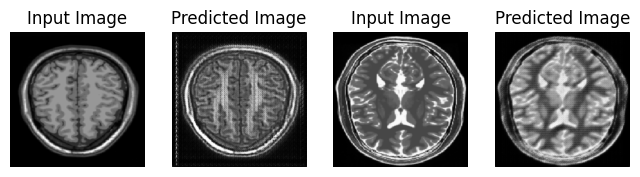

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-2

Epoch 3/30
Avg Losses -> GenG: 1.0702, GenF: 1.0853, Cycle: 1.8071, Identity: 0.1191, DiscX: 0.5700, DiscY: 0.5697


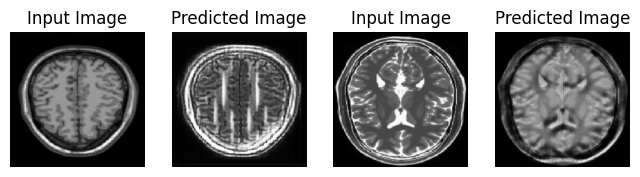

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-3

Epoch 4/30
Avg Losses -> GenG: 1.0117, GenF: 0.9861, Cycle: 1.8675, Identity: 0.1328, DiscX: 0.6142, DiscY: 0.5861


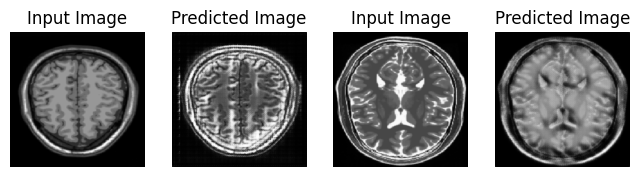

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-4

Epoch 5/30
Avg Losses -> GenG: 1.0269, GenF: 0.9650, Cycle: 1.6680, Identity: 0.1343, DiscX: 0.5872, DiscY: 0.5823


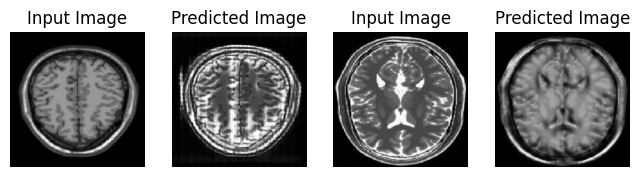

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-5

Epoch 6/30
Avg Losses -> GenG: 0.9790, GenF: 0.9493, Cycle: 1.5697, Identity: 0.1303, DiscX: 0.5900, DiscY: 0.5757


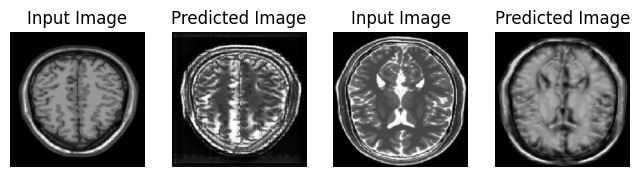

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-6

Epoch 7/30
Avg Losses -> GenG: 0.9609, GenF: 0.9680, Cycle: 1.5322, Identity: 0.1284, DiscX: 0.6172, DiscY: 0.5983


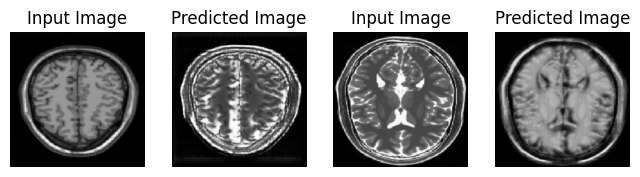

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-7

Epoch 8/30
Avg Losses -> GenG: 0.9744, GenF: 0.9267, Cycle: 1.4313, Identity: 0.1221, DiscX: 0.5836, DiscY: 0.5929


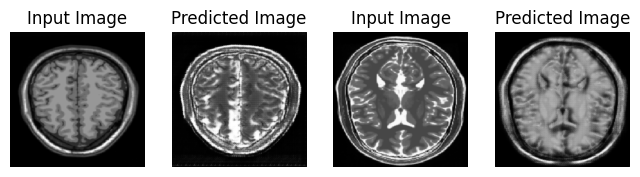

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-8

Epoch 9/30
Avg Losses -> GenG: 0.9451, GenF: 0.9694, Cycle: 1.4347, Identity: 0.1172, DiscX: 0.6519, DiscY: 0.5800


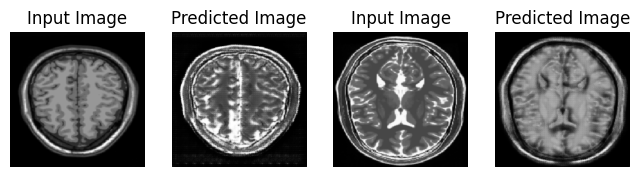

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-9

Epoch 10/30
Avg Losses -> GenG: 0.9683, GenF: 0.8980, Cycle: 1.3924, Identity: 0.1150, DiscX: 0.6030, DiscY: 0.6082


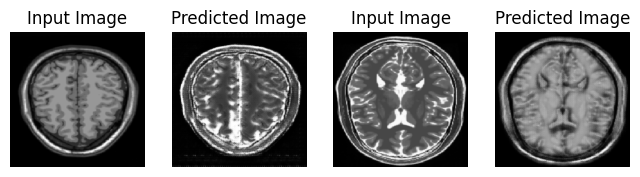

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-10

Epoch 11/30
Avg Losses -> GenG: 0.9478, GenF: 0.9029, Cycle: 1.3590, Identity: 0.1114, DiscX: 0.5905, DiscY: 0.5828


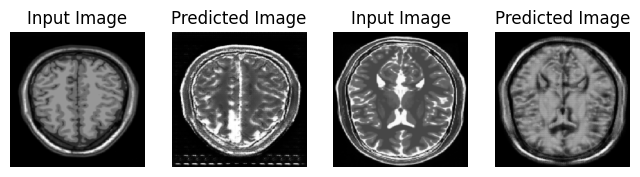

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-11

Epoch 12/30
Avg Losses -> GenG: 0.9455, GenF: 0.9202, Cycle: 1.3310, Identity: 0.1101, DiscX: 0.6077, DiscY: 0.5849


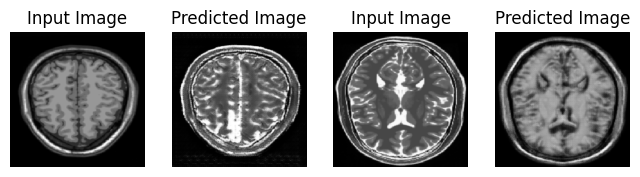

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-12

Epoch 13/30
Avg Losses -> GenG: 0.9424, GenF: 0.9208, Cycle: 1.3193, Identity: 0.1111, DiscX: 0.5963, DiscY: 0.5896


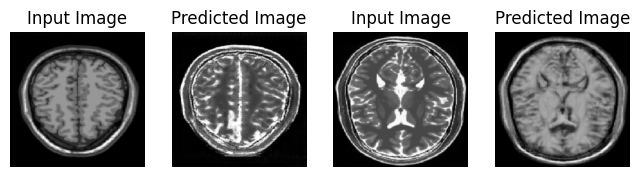

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-13

Epoch 14/30
Avg Losses -> GenG: 0.9272, GenF: 0.9886, Cycle: 1.3113, Identity: 0.1124, DiscX: 0.5812, DiscY: 0.5882


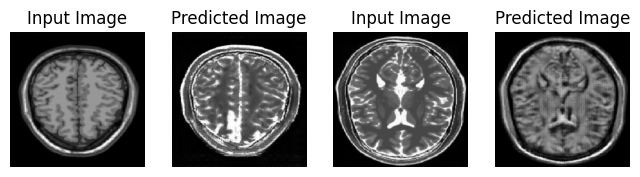

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-14

Epoch 15/30
Avg Losses -> GenG: 1.0297, GenF: 0.9880, Cycle: 1.2711, Identity: 0.1130, DiscX: 0.8934, DiscY: 0.6696


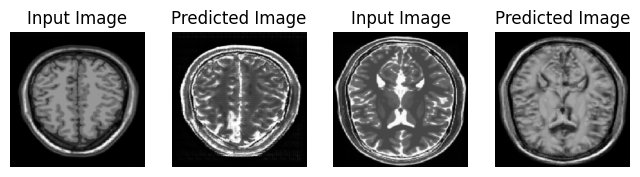

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-15

Epoch 16/30
Avg Losses -> GenG: 0.9630, GenF: 0.7693, Cycle: 1.0889, Identity: 0.1056, DiscX: 0.6644, DiscY: 0.7710


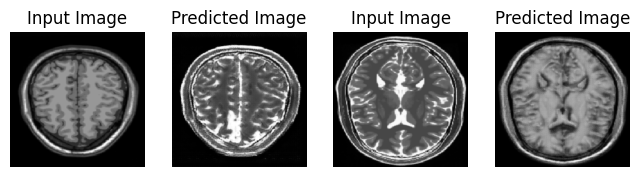

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-16

Epoch 17/30
Avg Losses -> GenG: 0.8733, GenF: 0.8320, Cycle: 1.1200, Identity: 0.1048, DiscX: 0.6361, DiscY: 0.5862


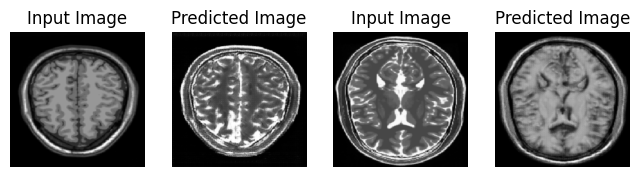

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-17

Epoch 18/30
Avg Losses -> GenG: 0.8699, GenF: 1.0131, Cycle: 1.1816, Identity: 0.1073, DiscX: 0.5564, DiscY: 0.5906


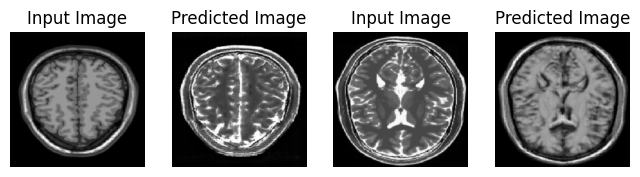

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-18

Epoch 19/30
Avg Losses -> GenG: 0.9036, GenF: 1.2187, Cycle: 1.2435, Identity: 0.1089, DiscX: 0.5573, DiscY: 0.5851


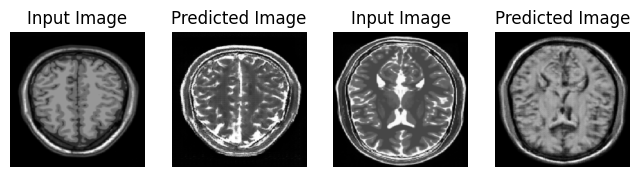

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-19

Epoch 20/30
Avg Losses -> GenG: 0.8982, GenF: 1.6296, Cycle: 1.2932, Identity: 0.1191, DiscX: 0.4641, DiscY: 0.5852


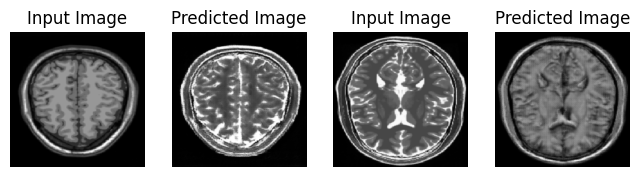

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-20

Epoch 21/30
Avg Losses -> GenG: 0.9103, GenF: 1.4820, Cycle: 1.3188, Identity: 0.1245, DiscX: 0.5353, DiscY: 0.5876


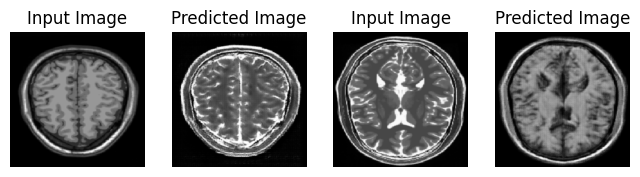

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-21

Epoch 22/30
Avg Losses -> GenG: 0.9157, GenF: 1.2764, Cycle: 1.2811, Identity: 0.1228, DiscX: 0.5789, DiscY: 0.5755


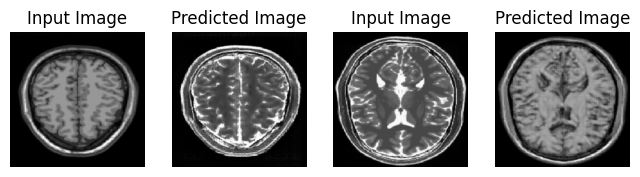

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-22

Epoch 23/30
Avg Losses -> GenG: 1.1054, GenF: 1.5238, Cycle: 1.3263, Identity: 0.1264, DiscX: 0.4827, DiscY: 0.7129


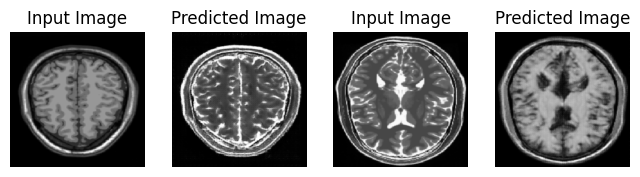

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-23

Epoch 24/30
Avg Losses -> GenG: 0.8445, GenF: 1.4574, Cycle: 1.2179, Identity: 0.1226, DiscX: 0.4683, DiscY: 0.6862


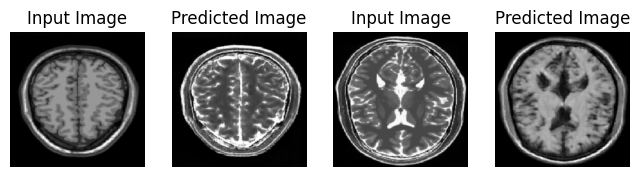

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-24

Epoch 25/30
Avg Losses -> GenG: 0.9109, GenF: 1.8556, Cycle: 1.2272, Identity: 0.1209, DiscX: 0.4399, DiscY: 0.5626


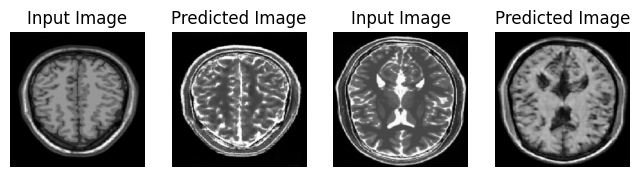

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-25

Epoch 26/30
Avg Losses -> GenG: 1.3754, GenF: 1.5384, Cycle: 1.3256, Identity: 0.1235, DiscX: 0.5217, DiscY: 0.4673


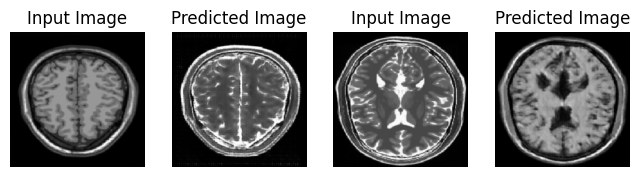

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-26

Epoch 27/30
Avg Losses -> GenG: 2.1977, GenF: 1.7236, Cycle: 1.8316, Identity: 0.1578, DiscX: 0.4335, DiscY: 0.3988


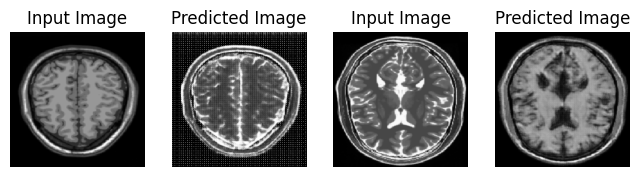

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-27

Epoch 28/30
Avg Losses -> GenG: 2.3301, GenF: 1.7116, Cycle: 1.7058, Identity: 0.1619, DiscX: 0.5582, DiscY: 0.3642


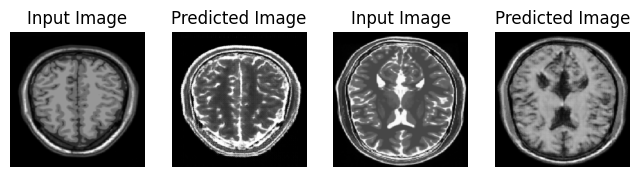

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-28

Epoch 29/30
Avg Losses -> GenG: 2.5090, GenF: 1.5612, Cycle: 1.4416, Identity: 0.1398, DiscX: 0.4553, DiscY: 0.3437


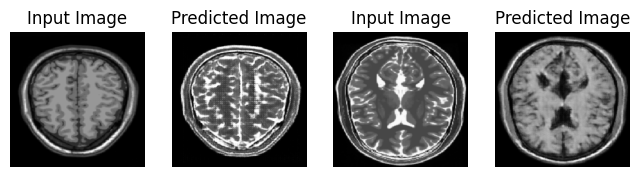

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-29

Epoch 30/30
Avg Losses -> GenG: 2.7798, GenF: 1.7501, Cycle: 1.5233, Identity: 0.1364, DiscX: 0.5351, DiscY: 0.2717


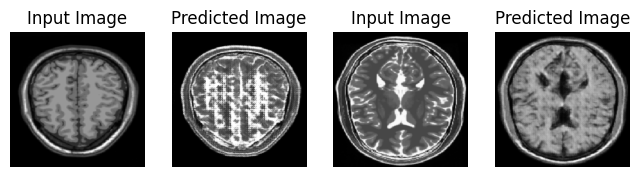

Checkpoint saved at ./Output/20250509110606/Trained_Model/ckpt-30


In [169]:
for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    
    total_losses = {
        'gen_g_loss': 0,
        'gen_f_loss': 0,
        'cycle_loss': 0,
        'identity_loss': 0,
        'disc_x_loss': 0,
        'disc_y_loss': 0
    }

    steps = 0
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        losses = train_step(image_x, image_y)
        for key in total_losses:
            total_losses[key] += losses[key]
        steps += 1

    avg_losses = {k: v / steps for k, v in total_losses.items()}
    print(f"Avg Losses -> GenG: {avg_losses['gen_g_loss']:.4f}, GenF: {avg_losses['gen_f_loss']:.4f}, "
          f"Cycle: {avg_losses['cycle_loss']:.4f}, Identity: {avg_losses['identity_loss']:.4f}, "
          f"DiscX: {avg_losses['disc_x_loss']:.4f}, DiscY: {avg_losses['disc_y_loss']:.4f}")

    generate_images(generator_g, sample_t1_data, generator_f, sample_t2_data, epoch)
    ckpt_save_path = ckpt_manager.save()
    print('Checkpoint saved at', ckpt_save_path)

### Model Visualization

In [170]:
anim_file = TEMP_FOLDER + 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob( TEMP_FOLDER + 'image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/tmp/ipykernel_31/2460268509.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_31/2460268509.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



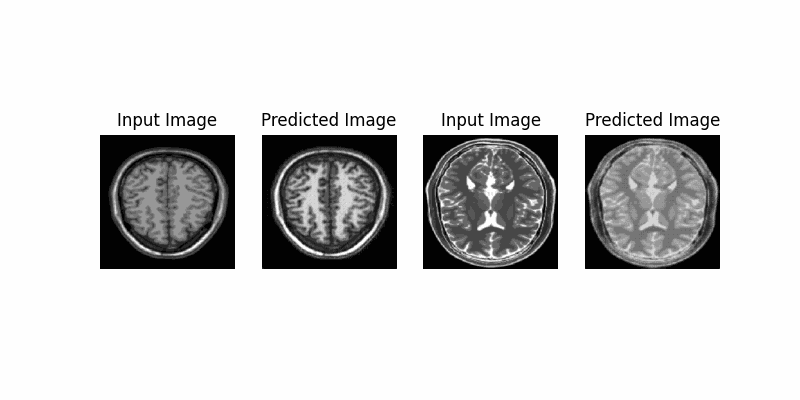

In [171]:
embed.embed_file(anim_file)

### Model Testing

In [172]:
def test_model(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(5, 5))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

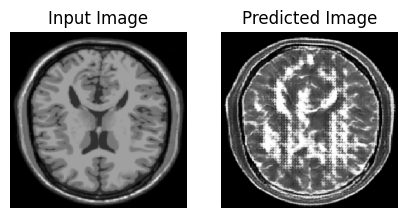

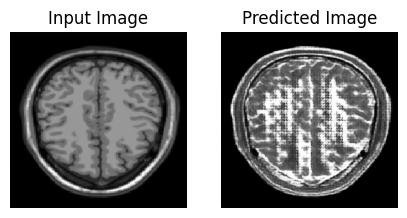

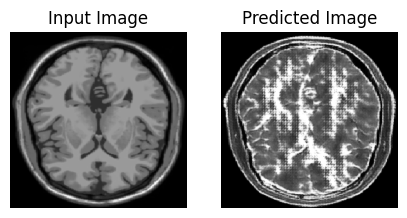

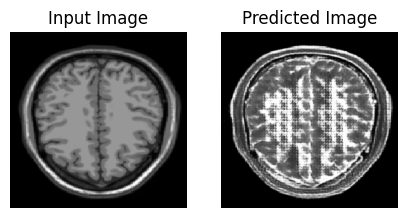

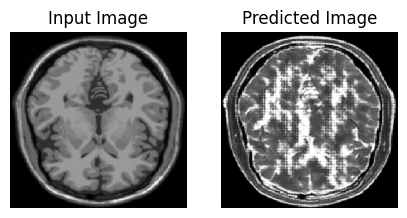

In [173]:
# Run the trained model on the test dataset
for inp in tr1.take(5):
    test_model(generator_g, inp)

In [174]:
# %load_ext tensorboard

# %reload_ext tensorboard
# %tensorboard --logdir ./logs/

# tf.saved_model.save( generator_g, './Output/')